In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

In [4]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [5]:
from solver import deasolver

In [6]:
results = []
df_imp = pd.DataFrame()

In [57]:
df = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy 3.xlsx", index_col = 0)

In [58]:
df.head()

,Input_owners’ equity,Input_total operational expences,Input_operational income,Output_net profit
1,1.355335e+09,4.813198e+08,4.818634e+08,1.169624e+08
2,6.172486e+09,1.468911e+09,1.876007e+09,5.305416e+08
3,8.134738e+09,6.379069e+09,6.449506e+09,4.194821e+08
4,2.222073e+09,1.128459e+09,1.053529e+09,3.893530e+07
5,1.830483e+09,4.110728e+09,4.664999e+09,4.720929e+08


In [59]:
(df<0).sum()

Input_owners’ equity                 0
Input_total operational expences     0
Input_operational income             0
Output_net profit                   64
dtype: int64

In [60]:
df["Output_net profit"].describe()

count    9.480000e+02
mean     3.748199e+08
std      1.850877e+09
min     -9.101232e+09
25%      4.387254e+07
50%      9.719600e+07
75%      2.379658e+08
max      4.117224e+10
Name: Output_net profit, dtype: float64

In [66]:
(df["Output_net profit"] + (df["Output_net profit"].min() * -1) + 1).describe()

count    9.480000e+02
mean     9.476052e+09
std      1.850877e+09
min      1.000000e+00
25%      9.145105e+09
50%      9.198428e+09
75%      9.339198e+09
max      5.027347e+10
Name: Output_net profit, dtype: float64

In [67]:
df["Output_net profit"] = df["Output_net profit"] + (df["Output_net profit"].min() * -1) + 1

In [68]:
deasolver(inputfile="Data/RealData/jmse_37_Data_V3 copy 3.xlsx", folder = "Data/RealData/", out_suffix1="_Sol")

100.0
Solution file saved outputfile


In [69]:
df_weights = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy 3_Sol.xlsx", index_col = 0).iloc[:, 1:]
df_weights

,Weight_Input_operational income,Weight_Input_owners’ equity,Weight_Input_total operational expences,Weight_Output_net profit
1,3.357797e-10,6.184450e-10,0.000000e+00,2.230087e-09
2,0.000000e+00,1.239739e-10,1.598279e-10,5.017678e-10
3,4.665875e-11,8.593690e-11,0.000000e+00,3.098849e-10
4,1.943188e-10,3.578997e-10,0.000000e+00,1.290572e-09
5,0.000000e+00,5.463039e-10,0.000000e+00,1.199859e-09
...,...,...,...,...
944,0.000000e+00,6.065330e-11,0.000000e+00,1.332142e-10
945,7.331197e-11,1.350273e-10,0.000000e+00,4.869028e-10
946,0.000000e+00,7.682075e-10,0.000000e+00,1.687231e-09
947,0.000000e+00,7.494201e-10,0.000000e+00,1.645968e-09


In [70]:
(df_weights["Weight_Input_total operational expences"]<df_weights["Weight_Input_owners’ equity"]).sum()

890

In [71]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input_operational income            410
Weight_Input_owners’ equity                 13
Weight_Input_total operational expences    890
Weight_Output_net profit                    64
dtype: int64

### ML

In [72]:
X = df.iloc[:,:-1]
X.head()

,Input_owners’ equity,Input_total operational expences,Input_operational income
1,1.355335e+09,4.813198e+08,4.818634e+08
2,6.172486e+09,1.468911e+09,1.876007e+09
3,8.134738e+09,6.379069e+09,6.449506e+09
4,2.222073e+09,1.128459e+09,1.053529e+09
5,1.830483e+09,4.110728e+09,4.664999e+09


In [73]:
y = df.iloc[:,-1:]
y.head()

,Output_net profit
1,9.218195e+09
2,9.631774e+09
3,9.520714e+09
4,9.140167e+09
5,9.573325e+09


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [76]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -1.8916894810772365e+18
neg_root_mean_squared_error: -1003252577.3543837
r2: 0.3932373861689084


In [77]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [78]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [79]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [80]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-933401414.0160824
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 2000, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': None, 'gradientboostingregressor__learning_rate': 0.1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=None, n_estimators=2000,
                                           random_state=42, subsample=0.3))])
r2: 0.5179005859371022


In [81]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.37, 0.23, 0.41])

In [82]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
2,Input_operational income,0.405086
0,Input_owners’ equity,0.368021
1,Input_total operational expences,0.226893


In [24]:
input_imp = list(df_gb["Feature Name"].values)
results.append((0, grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

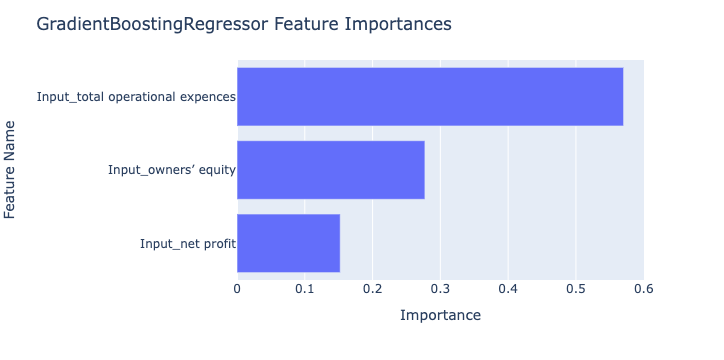

In [25]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=600,
    height=300,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [26]:
df_gb

,Feature Name,Importance
1,Input_total operational expences,0.570400
0,Input_owners’ equity,0.277276
2,Input_net profit,0.152323


In [27]:
df_zero.index = ["_".join(f.split("_")[1:]) for f in df_zero.index]

In [28]:
df_zero

Input_net profit                    21
Input_owners’ equity                29
Input_total operational expences     3
Output_operational income            0
dtype: int64

In [29]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Input_total operational expences,0.570400,Input_total operational expences,3
1,Input_owners’ equity,0.277276,Input_owners’ equity,29
2,Input_net profit,0.152323,Input_net profit,21


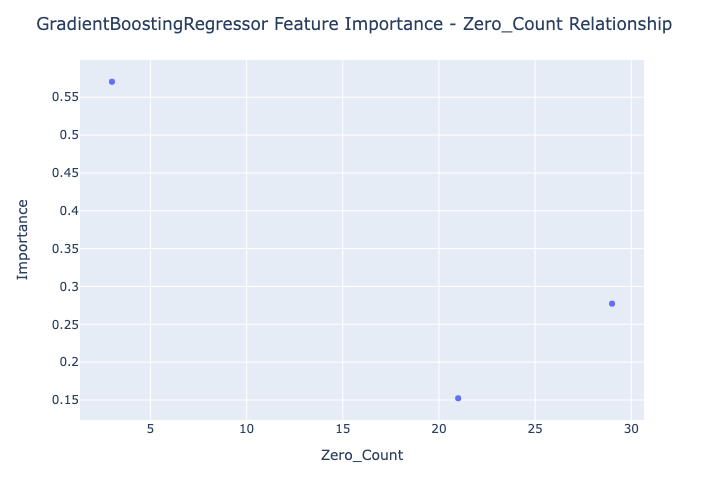

In [30]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

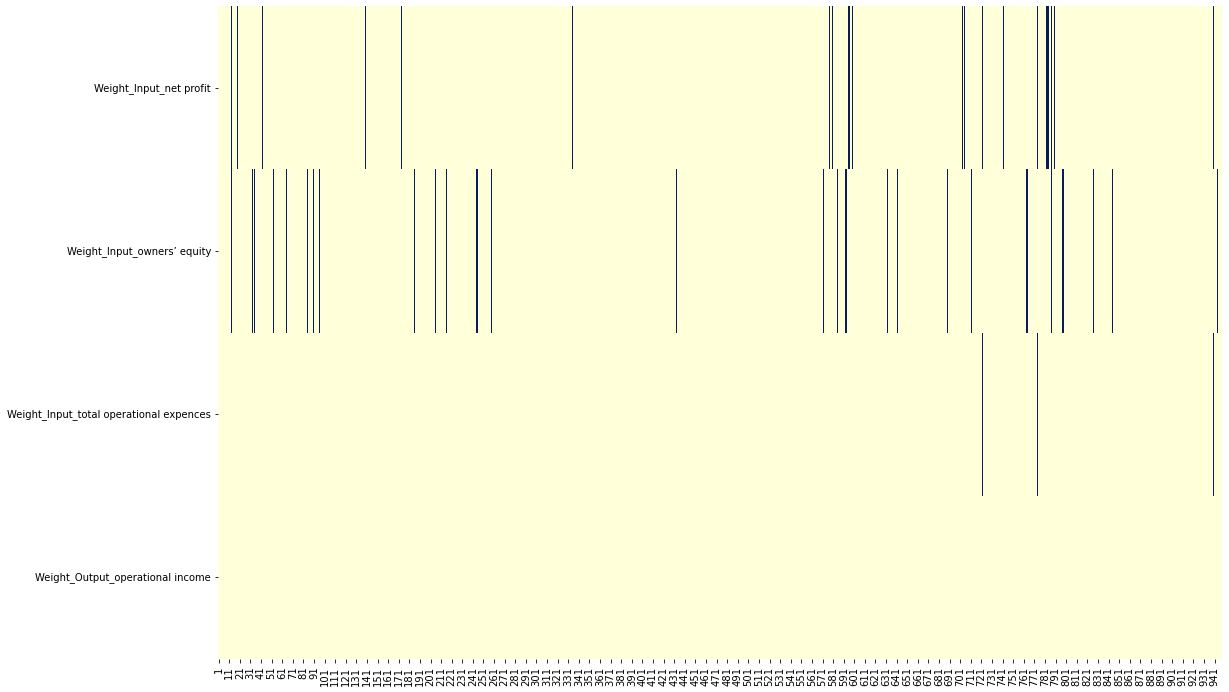

In [31]:
plt.figure(figsize=(18,12))
sns.heatmap(df_weights.eq(0).transpose(),
        cmap="YlGnBu",
        cbar=False,
        cbar_kws={'label': 'Zero Values'});

In [32]:
results 

[(0,
  'gradientboostingregressor',
  ['Input_total operational expences',
   'Input_owners’ equity',
   'Input_net profit'],
  {'r2': 0.8782581219660033,
   'neg_root_mean_squared_error': -16485379369.464136})]

In [33]:
results[0]

(0,
 'gradientboostingregressor',
 ['Input_total operational expences',
  'Input_owners’ equity',
  'Input_net profit'],
 {'r2': 0.8782581219660033,
  'neg_root_mean_squared_error': -16485379369.464136})

In [34]:
deasolver(inputfile="Data/RealData/jmse_37_Data_V3 copy 3.xlsx", folder = "Data/RealData/", out_suffix1="_Sol_1", input_imp = results[0])

100.0
Solution file saved outputfile


In [35]:
df_weights_1 = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy 3_Sol_1.xlsx", index_col = 0).iloc[:, 1:]
df_weights_1

,Weight_Input_net profit,Weight_Input_owners’ equity,Weight_Input_total operational expences,Weight_Output_operational income
1,1.888536e-10,1.888536e-10,1.499941e-09,1.061997e-09
2,5.443767e-11,5.443767e-11,4.323629e-10,3.061240e-10
3,9.996227e-11,1.214454e-11,1.347023e-10,1.232685e-10
4,1.897748e-10,1.897748e-10,5.059265e-10,5.134209e-10
5,9.476313e-11,6.706256e-11,2.025204e-10,2.052284e-10
...,...,...,...,...
944,1.230691e-11,1.230691e-11,3.280938e-11,3.329539e-11
945,3.731718e-11,3.731718e-11,2.963860e-10,2.098488e-10
946,7.217393e-11,7.217393e-11,1.924107e-10,1.952609e-10
947,1.203016e-10,8.513578e-11,2.570992e-10,2.605370e-10


In [36]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input_net profit                    21
Weight_Input_owners’ equity                29
Weight_Input_total operational expences     3
Weight_Output_operational income            0
dtype: int64

In [46]:
df_res = df_es.join(df_es_1, lsuffix = "_Basic", rsuffix="_with_ML")

In [37]:
df_es = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy 3_Sol.xlsx", index_col = 0).iloc[:, :1]
df_es_1 = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy 3_Sol_1.xlsx", index_col = 0).iloc[:, :1]

In [38]:
es = (df_es.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es}")

count of efficient units : 3


In [39]:
es_1 = (df_es_1.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es_1}")

count of efficient units : 3


In [46]:
df_res = df_es.join(df_es_1, lsuffix = "_Basic", rsuffix="_with_ML")

In [48]:
df_res[40:60]

,Efficiency_Scores_Basic,Efficiency_Scores_with_ML
41,0.850445,0.850445
42,0.999178,3.347792
43,0.867483,0.867483
44,0.928274,0.919642
45,0.713551,0.554874
...,...,...
56,0.763195,0.763195
57,0.716105,0.558248
58,0.803892,0.615593
59,0.840551,0.840551


In [43]:
df_res["Diff"] = df_res["Efficiency_Scores_Basic"]  - df_res["Efficiency_Scores_with_ML"]
df_res["Diff_Perc"] = (df_res["Diff"] / df_res["Efficiency_Scores_Basic"]) * 100 
df_res["Diff_Perc < 10"] = np.abs(df_res["Diff_Perc"]) < 10  
df_res = df_res.round(4)
df_res

,Efficiency_Scores_Basic,Efficiency_Scores_with_ML,Diff,Diff_Perc,Diff_Perc < 10
1,0.6611,0.5117,0.1493,22.5908,False
2,0.7526,0.5743,0.1783,23.6900,False
3,0.7950,0.7950,0.0000,0.0000,True
4,0.7234,0.5409,0.1824,25.2224,False
5,0.9574,0.9574,0.0000,0.0000,True
...,...,...,...,...,...
944,0.9871,0.8107,0.1764,17.8685,False
945,0.7531,0.5357,0.2174,28.8680,False
946,0.9072,0.8991,0.0082,0.8990,True
947,0.9050,0.9050,0.0000,0.0000,True


In [44]:
blue = df_res["Diff_Perc < 10"].sum()
print("blue : ", blue)
red = len(df_res["Diff_Perc < 10"]) - (df_res["Diff_Perc < 10"].sum())
print("red : ", red)

blue :  586
red :  362


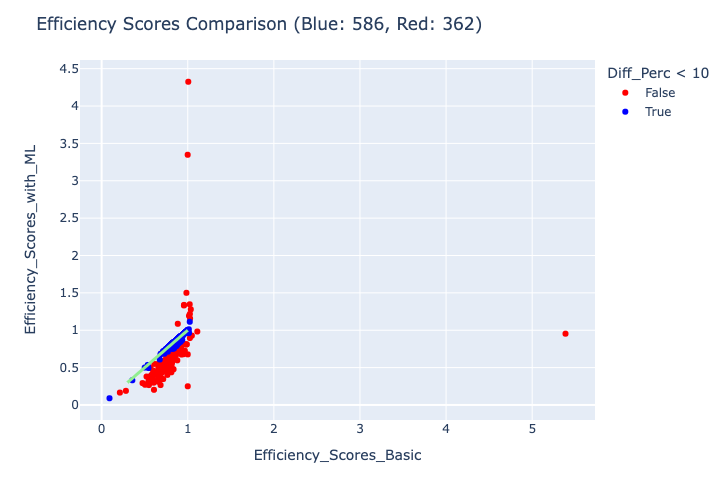

In [45]:
fig = px.scatter(df_res, x="Efficiency_Scores_Basic", y="Efficiency_Scores_with_ML", color = "Diff_Perc < 10", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Efficiency_Scores_Basic", "Efficiency_Scores_with_ML", "Diff_Perc"] + [df_res.index])

fig.add_traces(
    list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
)

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Efficiency Scores Comparison (Blue: {blue}, Red: {red})",
)

fig.show()